In [ ]:
using JuMP, HiGHS
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
include("../src/unit_commitments.jl")
ENV["COLUMNS"]=120; 
datadir = joinpath("../WECC") 

gen_info = CSV.read(joinpath(datadir,"Generators_data.csv"), DataFrame);
fuels = CSV.read(joinpath(datadir,"Fuels_data.csv"), DataFrame);
loads = CSV.read(joinpath(datadir,"Load_data.csv"), DataFrame);
gen_var = CSV.read(joinpath(datadir,"Generators_variability.csv"), DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads, gen_var, network]
    rename!(f,lowercase.(names(f)))
end

select!(gen_info, Not(["commit", "heat_rate_mmbtu_mwh_iqr", "heat_rate_mmbtu_mwh_std"]))
select!(loads, Not(1:4)) # remove unnecessary columns
rename!(loads, :time_index => :hour)
loads.demand = [sum(row) for row in eachrow(select(loads, Not(:hour)))]
loads = select(loads, [:hour, :demand])

gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame

rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0
dropmissing!(gen_df)
gen_df.fuel[gen_df.hydro .== 1] .= "hydro"

# make gen_var columns r_id
rename!(gen_var, names(gen_var)[1] => :hour)
for i in 1:length(names(gen_var))-1
    rename!(gen_var, names(gen_var)[i+1] => Symbol(i))
end

gen_var_long = stack(gen_var, 
                    Not(:hour), variable_name=:r_id,
                                        value_name=:cf)
gen_var_long.r_id = parse.(Int, gen_var_long.r_id); # r_ids should be int

In [7]:
include("../src/functions.jl")
# A spring day
n=100
T_period = (n*24+6):(n*24+30)

# gen_df = gen_df[gen_df.r_id .!= 119, :]

# gen_df = gen_df[gen_df.technology .!= "Conventional Hydroelectric", :]
loads_multi = loads[in.(loads.hour,Ref(T_period)),:]

gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

solution = unit_commitment_no_transport(
    gen_df, loads_multi, gen_var_multi, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 49449 rows; 26350 cols; 150175 nonzeros; 10425 integer variables (10425 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 9e+04]
Presolving model
36390 rows, 25920 cols, 130588 nonzeros  0s
27803 rows, 20783 cols, 113414 nonzeros  0s
20586 rows, 19085 cols, 103189 nonzeros  0s
17592 rows, 16121 cols, 98672 nonzeros  1s
15830 rows, 14460 cols, 93688 nonzeros  3s

Solving MIP model with:
   15830 rows
   14460 cols (8846 binary, 0 integer, 0 implied int., 5614 continuous, 0 domain fixed)
   93688 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =

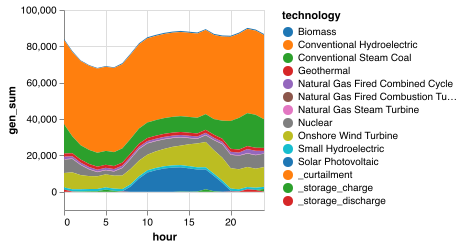

In [8]:
# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :technology]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:technology, :hour]), 
            :gen => sum)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :curt => sum)
curtail[!, :technology] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen, curtail[:,[:technology, :hour, :gen_sum]])

# Add storage discharge
for (storagetype, storagelabel, df) in [
    ("discharge", "_storage_discharge", solution.discharge_df),
    ("charge", "_storage_charge", solution.charge_df)
    ]
    storage_plot = combine(groupby(df, :hour), :value => sum)
    storage_plot[!, :technology] .= storagelabel
    rename!(storage_plot, :value_sum => :gen_sum)
    append!(sol_gen, storage_plot[:, [:technology, :hour, :gen_sum]])
end

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"technology:n", scale={scheme="category10"}})

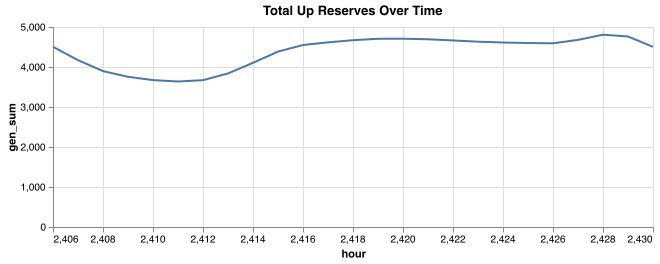

In [9]:
using VegaLite

reserves_plot = combine(groupby(solution.reserves, :hour), :gen => sum)
reserves_plot |>
@vlplot(:line, x=:hour, y=:gen_sum, title="Total Up Reserves Over Time", width=600)